In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

from utils import seed
from data import dataset
from model.backbone import VGG16, ResNet34
from model.simclr import basic_simclr, data_aug, simclr_train
from model import basic_classifier
from utils import train

seed.seed_everything()

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# VGG

In [3]:
# (already downloaded) dataset path 
path = './data'

train_loader, val_loader, test_loader = dataset.load_pcam(path=path, 
                                                          input_shape=96,
                                                          augmentation=True,
                                                          normalize=True,
                                                          batch_size=256,
                                                          seed=21)

In [4]:
backbone = VGG16.VGG16_Backbone(pretrain=False).to(device=device)
model_temp = basic_simclr.BasicSimCLR(backbone, num_classes=64).to(device=device)

# path - VGG 
log_dir = 'checkpoints/Mar30_11-40-32'
file_path = 'checkpoint_0100.pth.tar'

checkpoint_path = os.path.join(log_dir, file_path)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_temp.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
# backbone from SimCLR
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

print(model)

BasicClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [6]:
# Warm-up stage 
# 0 ~ 10 epochs
EPOCHS = 10

criterion = nn.BCELoss()
# higher lr for warm-up
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf

In [7]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=None, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:14<00:00,  1.85it/s]


epoch 01, loss: 0.49849, accuracy: 0.76076, val_loss: 0.53238, val_accuracy: 0.72806 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


epoch 02, loss: 0.46439, accuracy: 0.78178, val_loss: 0.49261, val_accuracy: 0.76505 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


epoch 03, loss: 0.45137, accuracy: 0.79050, val_loss: 0.47641, val_accuracy: 0.77100 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


epoch 04, loss: 0.44605, accuracy: 0.79376, val_loss: 0.47908, val_accuracy: 0.77084 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


epoch 05, loss: 0.44270, accuracy: 0.79622, val_loss: 0.47794, val_accuracy: 0.77194 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


epoch 06, loss: 0.43939, accuracy: 0.79869, val_loss: 0.45657, val_accuracy: 0.77783 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


epoch 07, loss: 0.43835, accuracy: 0.79880, val_loss: 0.47363, val_accuracy: 0.77524 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


epoch 08, loss: 0.43594, accuracy: 0.80091, val_loss: 0.47226, val_accuracy: 0.77469 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


epoch 09, loss: 0.43580, accuracy: 0.80106, val_loss: 0.47515, val_accuracy: 0.77652 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


epoch 10, loss: 0.43521, accuracy: 0.80117, val_loss: 0.45088, val_accuracy: 0.78143 



In [8]:
# freezing True -> False 
for param in model.backbone.parameters():
    param.requires_grad = True

In [9]:
# Fine-tuning stage 
# 10 ~ 50 epochs
EPOCHS = 40

criterion = nn.BCELoss()
# lower lr for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-3)
es = train.EarlyStopping(patience=EPOCHS//2, delta=0, mode='min', verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS//5, gamma=0.9)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf    

In [10]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=scheduler, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    es(val_loss)
    # Early Stop Check
    if es.early_stop:
        break

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(model.state_dict(), 'Best_Model_VGG_4.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:34<00:00,  1.26it/s]


[EarlyStopping] (Update) Best Score: 0.34976
[INFO] val_loss has been improved from inf to 0.34976. Save model.
epoch 01, loss: 0.27475, accuracy: 0.89290, val_loss: 0.34976, val_accuracy: 0.86777 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:13<00:00,  1.29it/s]


[EarlyStopping] (Update) Best Score: 0.28114
[INFO] val_loss has been improved from 0.34976 to 0.28114. Save model.
epoch 02, loss: 0.18854, accuracy: 0.93034, val_loss: 0.28114, val_accuracy: 0.88870 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:13<00:00,  1.29it/s]


[EarlyStopping] (Patience) 1/20, Best: 0.28114, Current: 0.36787, Delta: 0.08673
epoch 03, loss: 0.17068, accuracy: 0.93802, val_loss: 0.36787, val_accuracy: 0.86899 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:13<00:00,  1.29it/s]


[EarlyStopping] (Update) Best Score: 0.25745
[INFO] val_loss has been improved from 0.28114 to 0.25745. Save model.
epoch 04, loss: 0.16221, accuracy: 0.94170, val_loss: 0.25745, val_accuracy: 0.89865 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 1/20, Best: 0.25745, Current: 0.42706, Delta: 0.16961
epoch 05, loss: 0.15380, accuracy: 0.94494, val_loss: 0.42706, val_accuracy: 0.85660 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 2/20, Best: 0.25745, Current: 0.28737, Delta: 0.02992
epoch 06, loss: 0.15043, accuracy: 0.94605, val_loss: 0.28737, val_accuracy: 0.89240 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 3/20, Best: 0.25745, Current: 0.32369, Delta: 0.06624
epoch 07, loss: 0.14652, accuracy: 0.94775, val_loss: 0.32369, val_accuracy: 0.87537 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:24<00:00,  1.27it/s]


[EarlyStopping] (Patience) 4/20, Best: 0.25745, Current: 0.27576, Delta: 0.01831
epoch 08, loss: 0.14524, accuracy: 0.94859, val_loss: 0.27576, val_accuracy: 0.89020 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Update) Best Score: 0.24539
[INFO] val_loss has been improved from 0.25745 to 0.24539. Save model.
epoch 09, loss: 0.13945, accuracy: 0.95034, val_loss: 0.24539, val_accuracy: 0.90320 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 1/20, Best: 0.24539, Current: 0.29501, Delta: 0.04962
epoch 10, loss: 0.13739, accuracy: 0.95150, val_loss: 0.29501, val_accuracy: 0.88702 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 2/20, Best: 0.24539, Current: 0.26770, Delta: 0.02231
epoch 11, loss: 0.13295, accuracy: 0.95318, val_loss: 0.26770, val_accuracy: 0.90143 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 3/20, Best: 0.24539, Current: 0.32802, Delta: 0.08262
epoch 12, loss: 0.13065, accuracy: 0.95416, val_loss: 0.32802, val_accuracy: 0.87552 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:19<00:00,  1.28it/s]


[EarlyStopping] (Patience) 4/20, Best: 0.24539, Current: 0.34224, Delta: 0.09684
epoch 13, loss: 0.12972, accuracy: 0.95409, val_loss: 0.34224, val_accuracy: 0.88461 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 5/20, Best: 0.24539, Current: 0.33085, Delta: 0.08545
epoch 14, loss: 0.12743, accuracy: 0.95488, val_loss: 0.33085, val_accuracy: 0.88733 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:23<00:00,  1.27it/s]


[EarlyStopping] (Patience) 6/20, Best: 0.24539, Current: 0.45728, Delta: 0.21189
epoch 15, loss: 0.12692, accuracy: 0.95570, val_loss: 0.45728, val_accuracy: 0.85126 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:23<00:00,  1.27it/s]


[EarlyStopping] (Patience) 7/20, Best: 0.24539, Current: 0.54496, Delta: 0.29957
epoch 16, loss: 0.12481, accuracy: 0.95649, val_loss: 0.54496, val_accuracy: 0.84830 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 8/20, Best: 0.24539, Current: 0.32909, Delta: 0.08370
epoch 17, loss: 0.12091, accuracy: 0.95788, val_loss: 0.32909, val_accuracy: 0.88391 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 9/20, Best: 0.24539, Current: 0.51545, Delta: 0.27006
epoch 18, loss: 0.12031, accuracy: 0.95794, val_loss: 0.51545, val_accuracy: 0.84256 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 10/20, Best: 0.24539, Current: 0.34971, Delta: 0.10431
epoch 19, loss: 0.11868, accuracy: 0.95847, val_loss: 0.34971, val_accuracy: 0.87396 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 11/20, Best: 0.24539, Current: 0.28798, Delta: 0.04258
epoch 20, loss: 0.11823, accuracy: 0.95938, val_loss: 0.28798, val_accuracy: 0.89633 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 12/20, Best: 0.24539, Current: 0.27018, Delta: 0.02479
epoch 21, loss: 0.11716, accuracy: 0.95924, val_loss: 0.27018, val_accuracy: 0.89297 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 13/20, Best: 0.24539, Current: 0.38794, Delta: 0.14255
epoch 22, loss: 0.11747, accuracy: 0.95950, val_loss: 0.38794, val_accuracy: 0.87155 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 14/20, Best: 0.24539, Current: 0.32151, Delta: 0.07612
epoch 23, loss: 0.11579, accuracy: 0.95949, val_loss: 0.32151, val_accuracy: 0.89047 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:23<00:00,  1.27it/s]


[EarlyStopping] (Patience) 15/20, Best: 0.24539, Current: 0.37790, Delta: 0.13251
epoch 24, loss: 0.11578, accuracy: 0.95947, val_loss: 0.37790, val_accuracy: 0.87076 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 16/20, Best: 0.24539, Current: 0.29889, Delta: 0.05349
epoch 25, loss: 0.11354, accuracy: 0.96055, val_loss: 0.29889, val_accuracy: 0.89279 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:23<00:00,  1.27it/s]


[EarlyStopping] (Patience) 17/20, Best: 0.24539, Current: 0.50119, Delta: 0.25580
epoch 26, loss: 0.11185, accuracy: 0.96147, val_loss: 0.50119, val_accuracy: 0.83575 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:22<00:00,  1.28it/s]


[EarlyStopping] (Patience) 18/20, Best: 0.24539, Current: 0.51016, Delta: 0.26476
epoch 27, loss: 0.11169, accuracy: 0.96129, val_loss: 0.51016, val_accuracy: 0.83606 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 19/20, Best: 0.24539, Current: 0.33783, Delta: 0.09244
epoch 28, loss: 0.11165, accuracy: 0.96115, val_loss: 0.33783, val_accuracy: 0.87903 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [13:21<00:00,  1.28it/s]


[EarlyStopping] (Patience) 20/20, Best: 0.24539, Current: 0.28071, Delta: 0.03532
[EarlyStop Triggered] Best Score: 0.24539


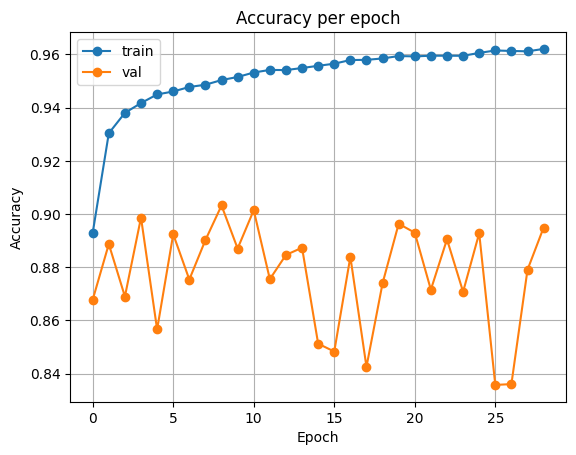

In [11]:
train.plot_acc(history=history)

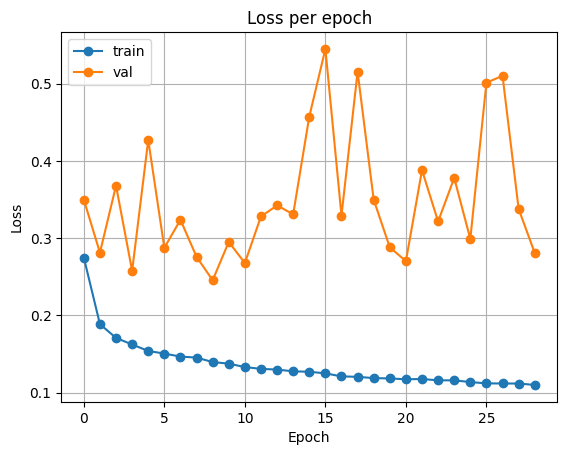

In [12]:
train.plot_loss(history=history)

In [13]:
backbone = VGG16.VGG16_Backbone(pretrain=False).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

model.load_state_dict(torch.load('Best_Model_VGG_4.pth', map_location=device))
model.eval()

test_loss, test_acc = train.model_evaluate(model=model,
                                           data_loader=test_loader,
                                           criterion=criterion,
                                           device=device)

print('Test Loss: %s'%test_loss)
print('Test Accuracy: %s'%test_acc)

Test Loss: 0.3218463254161179
Test Accuracy: 0.877227783203125


# ResNet

In [14]:
train_loader, val_loader, test_loader = dataset.load_pcam(path=path, 
                                                          input_shape=96,
                                                          augmentation=True,
                                                          normalize=True,
                                                          batch_size=256,
                                                          seed=21)

In [15]:
backbone = ResNet34.ResNet34_Backbone(pretrain=False).to(device=device)
model_temp = basic_simclr.BasicSimCLR(backbone, num_classes=64).to(device=device)

# path - ResNet
log_dir = 'checkpoints/Mar28_13-19-07'
file_path = 'checkpoint_0100.pth.tar'

checkpoint_path = os.path.join(log_dir, file_path)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_temp.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [16]:
# backbone from SimCLR
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

print(model)

BasicClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [17]:
# Warm-up stage 
# 0 ~ 10 epochs
EPOCHS = 10

criterion = nn.BCELoss()
# higher lr for warm-up
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf

In [18]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=None, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


epoch 01, loss: 0.41694, accuracy: 0.81708, val_loss: 0.44059, val_accuracy: 0.79453 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


epoch 02, loss: 0.37291, accuracy: 0.83658, val_loss: 0.39524, val_accuracy: 0.81760 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


epoch 03, loss: 0.36526, accuracy: 0.84076, val_loss: 0.39567, val_accuracy: 0.81638 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


epoch 04, loss: 0.35956, accuracy: 0.84294, val_loss: 0.38957, val_accuracy: 0.82114 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


epoch 05, loss: 0.35670, accuracy: 0.84470, val_loss: 0.39970, val_accuracy: 0.81421 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


epoch 06, loss: 0.35476, accuracy: 0.84593, val_loss: 0.40193, val_accuracy: 0.81699 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


epoch 07, loss: 0.35370, accuracy: 0.84573, val_loss: 0.39280, val_accuracy: 0.81985 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


epoch 08, loss: 0.35218, accuracy: 0.84705, val_loss: 0.39273, val_accuracy: 0.82233 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


epoch 09, loss: 0.35199, accuracy: 0.84732, val_loss: 0.39338, val_accuracy: 0.82098 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


epoch 10, loss: 0.35167, accuracy: 0.84678, val_loss: 0.38736, val_accuracy: 0.82245 



In [19]:
# freezing True -> False 
for param in model.backbone.parameters():
    param.requires_grad = True

In [20]:
# Fine-tuning stage 
# 10 ~ 50 epochs
EPOCHS = 40

criterion = nn.BCELoss()
# lower lr for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-3)
es = train.EarlyStopping(patience=EPOCHS//2, delta=0, mode='min', verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS//5, gamma=0.9)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf    

In [21]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=scheduler, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    es(val_loss)
    # Early Stop Check
    if es.early_stop:
        break

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(model.state_dict(), 'Best_Model_ResNet_4.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:54<00:00,  1.72it/s]


[EarlyStopping] (Update) Best Score: 0.31710
[INFO] val_loss has been improved from inf to 0.31710. Save model.
epoch 01, loss: 0.19824, accuracy: 0.92414, val_loss: 0.31710, val_accuracy: 0.87714 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:48<00:00,  1.74it/s]


[EarlyStopping] (Update) Best Score: 0.27361
[INFO] val_loss has been improved from 0.31710 to 0.27361. Save model.
epoch 02, loss: 0.16514, accuracy: 0.93916, val_loss: 0.27361, val_accuracy: 0.89972 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:48<00:00,  1.74it/s]


[EarlyStopping] (Patience) 1/20, Best: 0.27361, Current: 0.30208, Delta: 0.02847
epoch 03, loss: 0.15360, accuracy: 0.94359, val_loss: 0.30208, val_accuracy: 0.88696 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:48<00:00,  1.74it/s]


[EarlyStopping] (Patience) 2/20, Best: 0.27361, Current: 0.33633, Delta: 0.06272
epoch 04, loss: 0.14780, accuracy: 0.94618, val_loss: 0.33633, val_accuracy: 0.86307 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:49<00:00,  1.74it/s]


[EarlyStopping] (Patience) 3/20, Best: 0.27361, Current: 0.29965, Delta: 0.02604
epoch 05, loss: 0.14261, accuracy: 0.94764, val_loss: 0.29965, val_accuracy: 0.88080 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:47<00:00,  1.74it/s]


[EarlyStopping] (Patience) 4/20, Best: 0.27361, Current: 0.36576, Delta: 0.09215
epoch 06, loss: 0.13815, accuracy: 0.94987, val_loss: 0.36576, val_accuracy: 0.86685 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:48<00:00,  1.74it/s]


[EarlyStopping] (Patience) 5/20, Best: 0.27361, Current: 0.51929, Delta: 0.24568
epoch 07, loss: 0.13510, accuracy: 0.95091, val_loss: 0.51929, val_accuracy: 0.84155 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:49<00:00,  1.74it/s]


[EarlyStopping] (Patience) 6/20, Best: 0.27361, Current: 0.39166, Delta: 0.11805
epoch 08, loss: 0.13403, accuracy: 0.95155, val_loss: 0.39166, val_accuracy: 0.85953 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:48<00:00,  1.74it/s]


[EarlyStopping] (Patience) 7/20, Best: 0.27361, Current: 0.37148, Delta: 0.09787
epoch 09, loss: 0.12789, accuracy: 0.95451, val_loss: 0.37148, val_accuracy: 0.86960 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:49<00:00,  1.74it/s]


[EarlyStopping] (Patience) 8/20, Best: 0.27361, Current: 0.27960, Delta: 0.00599
epoch 10, loss: 0.12515, accuracy: 0.95534, val_loss: 0.27960, val_accuracy: 0.89703 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:50<00:00,  1.74it/s]


[EarlyStopping] (Patience) 9/20, Best: 0.27361, Current: 0.36877, Delta: 0.09516
epoch 11, loss: 0.12337, accuracy: 0.95617, val_loss: 0.36877, val_accuracy: 0.87656 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [14:12<00:00,  1.20it/s]


[EarlyStopping] (Patience) 10/20, Best: 0.27361, Current: 0.31612, Delta: 0.04251
epoch 12, loss: 0.12251, accuracy: 0.95657, val_loss: 0.31612, val_accuracy: 0.89020 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:45<00:00,  1.75it/s]


[EarlyStopping] (Patience) 11/20, Best: 0.27361, Current: 0.32490, Delta: 0.05130
epoch 13, loss: 0.12030, accuracy: 0.95715, val_loss: 0.32490, val_accuracy: 0.88171 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:46<00:00,  1.75it/s]


[EarlyStopping] (Patience) 12/20, Best: 0.27361, Current: 0.33421, Delta: 0.06060
epoch 14, loss: 0.12020, accuracy: 0.95700, val_loss: 0.33421, val_accuracy: 0.87668 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:46<00:00,  1.75it/s]


[EarlyStopping] (Patience) 13/20, Best: 0.27361, Current: 0.40946, Delta: 0.13585
epoch 15, loss: 0.11800, accuracy: 0.95781, val_loss: 0.40946, val_accuracy: 0.86624 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:44<00:00,  1.75it/s]


[EarlyStopping] (Patience) 14/20, Best: 0.27361, Current: 0.48652, Delta: 0.21291
epoch 16, loss: 0.11802, accuracy: 0.95768, val_loss: 0.48652, val_accuracy: 0.84998 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:45<00:00,  1.75it/s]


[EarlyStopping] (Patience) 15/20, Best: 0.27361, Current: 0.47908, Delta: 0.20547
epoch 17, loss: 0.11293, accuracy: 0.96045, val_loss: 0.47908, val_accuracy: 0.82889 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:46<00:00,  1.75it/s]


[EarlyStopping] (Patience) 16/20, Best: 0.27361, Current: 0.35694, Delta: 0.08333
epoch 18, loss: 0.11205, accuracy: 0.96036, val_loss: 0.35694, val_accuracy: 0.87332 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:47<00:00,  1.74it/s]


[EarlyStopping] (Patience) 17/20, Best: 0.27361, Current: 0.41249, Delta: 0.13888
epoch 19, loss: 0.11121, accuracy: 0.96075, val_loss: 0.41249, val_accuracy: 0.85217 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:46<00:00,  1.75it/s]


[EarlyStopping] (Patience) 18/20, Best: 0.27361, Current: 0.30267, Delta: 0.02906
epoch 20, loss: 0.10975, accuracy: 0.96161, val_loss: 0.30267, val_accuracy: 0.89508 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:47<00:00,  1.74it/s]


[EarlyStopping] (Patience) 19/20, Best: 0.27361, Current: 0.36586, Delta: 0.09225
epoch 21, loss: 0.10944, accuracy: 0.96179, val_loss: 0.36586, val_accuracy: 0.86819 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:48<00:00,  1.74it/s]


[EarlyStopping] (Patience) 20/20, Best: 0.27361, Current: 0.47000, Delta: 0.19639
[EarlyStop Triggered] Best Score: 0.27361


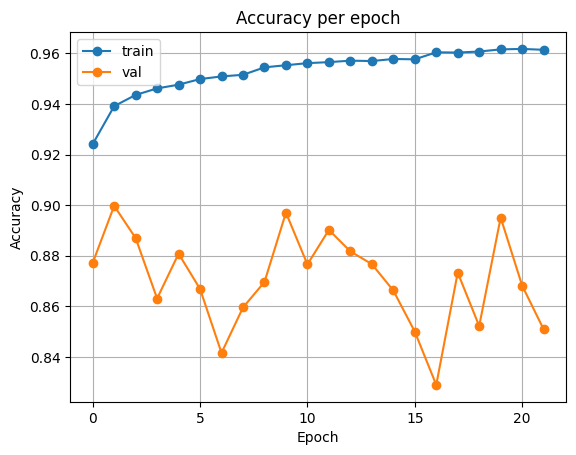

In [22]:
train.plot_acc(history=history)

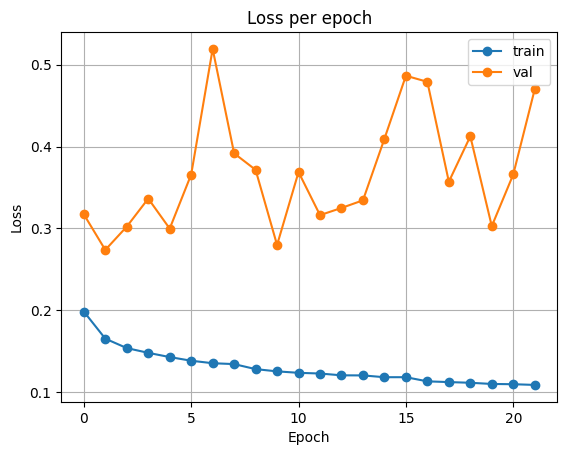

In [23]:
train.plot_loss(history=history)

In [24]:
backbone = ResNet34.ResNet34_Backbone(pretrain=False).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

model.load_state_dict(torch.load('Best_Model_ResNet_4.pth', map_location=device))
model.eval()

test_loss, test_acc = train.model_evaluate(model=model,
                                           data_loader=test_loader,
                                           criterion=criterion,
                                           device=device)

print('Test Loss: %s'%test_loss)
print('Test Accuracy: %s'%test_acc)

Test Loss: 0.40836958959698677
Test Accuracy: 0.84320068359375
